In [1]:
import os, time
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import KFold
from tqdm import tqdm

import torchvision.models as models
import torchvision.models.segmentation as segmodels


In [2]:
IMG_DIR  = "ISIC2018/ISIC2018/images_aug_20000"
MASK_DIR = "ISIC2018/ISIC2018/masks_aug_20000"

IMG_EXT  = ".jpg"
MASK_EXT = ".png"

FOLDS  = 0
EPOCHS = 3
BATCH  = 4
LR     = 3e-5
SEED   = 42

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

np.random.seed(SEED)
torch.manual_seed(SEED)


Device: cpu


In [3]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20, p=0.7),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])


C:\Users\Raed Shraideh\anaconda3\envs\jupyterlab\Lib\site-packages\albumentations\core\validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [4]:
class ISICSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, ids, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path  = os.path.join(self.img_dir, img_id + IMG_EXT)
        mask_path = os.path.join(self.mask_dir, img_id + MASK_EXT)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(mask_path)
        mask = (mask > 0).astype(np.float32)  

        if self.transform:
            out = self.transform(image=img, mask=mask)
            img = out["image"]
            mask = out["mask"]

        return img, mask.unsqueeze(0)  


In [5]:
all_ids = sorted([
    f.replace(IMG_EXT, "")
    for f in os.listdir(IMG_DIR)
    if f.endswith(IMG_EXT)
])

print("Total IDs:", len(all_ids))
print("Example:", all_ids[:5])


Total IDs: 20000
Example: ['ISIC_0000000', 'ISIC_0000000_aug_005082', 'ISIC_0000000_aug_010963', 'ISIC_0000001', 'ISIC_0000001_aug_002315']


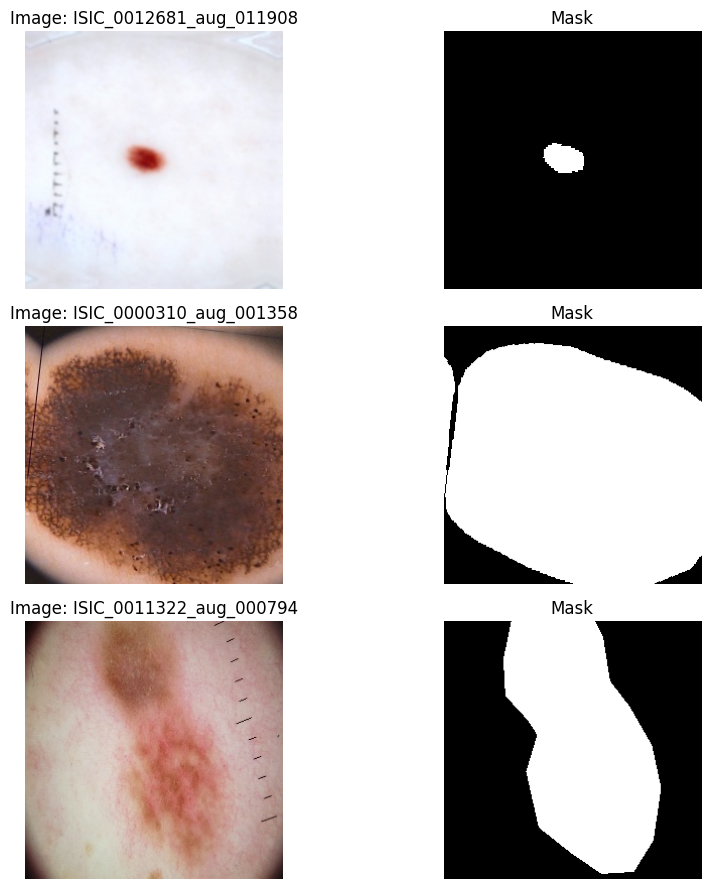

In [6]:
def show_samples(ids, n=3):
    pick = np.random.choice(ids, n, replace=False)
    plt.figure(figsize=(10, 3*n))
    for i, img_id in enumerate(pick, 1):
        img = cv2.imread(os.path.join(IMG_DIR, img_id + IMG_EXT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASK_DIR, img_id + MASK_EXT), 0)

        plt.subplot(n, 2, 2*i-1)
        plt.imshow(img); plt.axis("off"); plt.title(f"Image: {img_id}")

        plt.subplot(n, 2, 2*i)
        plt.imshow(mask, cmap="gray"); plt.axis("off"); plt.title("Mask")
    plt.tight_layout()
    plt.show()

show_samples(all_ids, n=3)


In [7]:
def save_model(model, model_name, fold, dice):
    os.makedirs("saved_models", exist_ok=True)
    path = f"saved_models/{model_name}_fold{fold}_dice{dice:.4f}.pth"
    torch.save(model.state_dict(), path)
    print(f"Saved model to: {path}")


In [8]:
bce_logits = nn.BCEWithLogitsLoss()

def dice_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    pred = (prob > 0.5).float()
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def soft_dice_loss_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    inter = (prob * target).sum(dim=(2,3))
    union = prob.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()


In [9]:
class VGG16_UNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

        self.enc1 = vgg[:5]    
        self.enc2 = vgg[5:10]  
        self.enc3 = vgg[10:17] 
        self.enc4 = vgg[17:24] 
        self.enc5 = vgg[24:31] 

        self.up = nn.Upsample(scale_factor=2, mode="nearest")

        def conv(i, o):
            return nn.Sequential(
                nn.Conv2d(i, o, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(o, o, 3, padding=1), nn.ReLU(inplace=True)
            )

        self.d5 = conv(512+512, 512)
        self.d4 = conv(512+256, 256)
        self.d3 = conv(256+128, 128)
        self.d2 = conv(128+64,   64)
        self.d1 = conv(64, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        d5 = self.d5(torch.cat([self.up(e5), e4], dim=1))
        d4 = self.d4(torch.cat([self.up(d5), e3], dim=1))
        d3 = self.d3(torch.cat([self.up(d4), e2], dim=1))
        d2 = self.d2(torch.cat([self.up(d3), e1], dim=1))

        d1 = self.d1(self.up(d2))  
        return self.final(d1)      


In [10]:
class ConvBlock(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i,o,3,1,1), nn.ReLU(True),
            nn.Conv2d(o,o,3,1,1), nn.ReLU(True),
        )
    def forward(self,x): return self.net(x)

class ResNet34_UNet(nn.Module):
    def __init__(self):
        super().__init__()
        r = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.e0 = nn.Sequential(r.conv1, r.bn1, r.relu)  
        self.e1 = nn.Sequential(r.maxpool, r.layer1)     
        self.e2 = r.layer2                               
        self.e3 = r.layer3                               
        self.e4 = r.layer4                               

        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.d3 = ConvBlock(512+256, 256)
        self.d2 = ConvBlock(256+128, 128)
        self.d1 = ConvBlock(128+64,   64)
        self.d0 = ConvBlock(64+64,     64)
        self.out = nn.Conv2d(64,1,1)

    def forward(self,x):
        a = self.e0(x)   
        b = self.e1(a)   
        c = self.e2(b)   
        d = self.e3(c)   
        e = self.e4(d)   

        x = self.d3(torch.cat([self.up(e), d], 1))   
        x = self.d2(torch.cat([self.up(x), c], 1))   
        x = self.d1(torch.cat([self.up(x), b], 1))   
        x = self.d0(torch.cat([self.up(x), a], 1))   
        x = self.up(x)                               
        return self.out(x)                           


In [11]:
class DeepLabV3_R50(nn.Module):
    def __init__(self):
        super().__init__()
        m = segmodels.deeplabv3_resnet50(weights="DEFAULT")
        m.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)  
        self.m = m

    def forward(self, x):
        return self.m(x)["out"]  


In [12]:
class FCN_R50(nn.Module):
    def __init__(self):
        super().__init__()
        m = segmodels.fcn_resnet50(weights="DEFAULT")
        m.classifier[4] = nn.Conv2d(512, 1, kernel_size=1)  
        self.m = m

    def forward(self, x):
        return self.m(x)["out"]  


In [13]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512,512,3,2,1,1), nn.ReLU(True),  
            nn.ConvTranspose2d(512,256,3,2,1,1), nn.ReLU(True), 
            nn.ConvTranspose2d(256,128,3,2,1,1), nn.ReLU(True),  
            nn.ConvTranspose2d(128,64, 3,2,1,1), nn.ReLU(True),  
            nn.ConvTranspose2d(64, 1,  3,2,1,1),                 
        )

    def forward(self, x):
        x = self.encoder(x)
        return self.decoder(x) 


In [14]:
def train_one_model(model, train_loader, val_loader, epochs=5):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR)

    history = {"train_loss": [], "val_loss": [], "val_dice": []}

    for ep in range(1, epochs + 1):
      
        model.train()
        train_loss_sum = 0.0
        start = time.time()

        loop = tqdm(train_loader, desc=f"Epoch {ep}/{epochs}", leave=True)
        for xb, yb in loop:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model(xb)
            loss = 0.5 * bce_logits(logits, yb) + 0.5 * soft_dice_loss_from_logits(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            train_loss_sum += loss.item()

           
            it = loop.n + 1
            elapsed = time.time() - start
            total = len(train_loader)
            eta = (elapsed / max(it, 1)) * (total - it)

            loop.set_postfix(batch_loss=f"{loss.item():.4f}", eta=f"{eta/60:.1f}m")

        train_loss = train_loss_sum / max(len(train_loader), 1)

     
        model.eval()
        val_loss_sum = 0.0
        val_dice_sum = 0.0
        n_batches = 0

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)

                vloss = 0.5 * bce_logits(logits, yb) + 0.5 * soft_dice_loss_from_logits(logits, yb)
                vdice = dice_from_logits(logits, yb)

                val_loss_sum += vloss.item()
                val_dice_sum += vdice
                n_batches += 1

        val_loss = val_loss_sum / max(n_batches, 1)
        val_dice = val_dice_sum / max(n_batches, 1)

        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["val_dice"].append(val_dice)

       
        print(f"Epoch {ep}/{epochs} | TrainLoss: {train_loss:.4f} | ValLoss: {val_loss:.4f} | ValDice: {val_dice:.4f}")

    return history, model


In [15]:
model_zoo = {
    "VGG16_UNet": VGG16_UNet,
    "ResNet34_UNet": ResNet34_UNet,
    "DeepLabV3_R50": DeepLabV3_R50,
    "FCN_R50": FCN_R50,
    "SegNet": SegNet,
}

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

cv_results = {name: [] for name in model_zoo}
best_models = {} 

for name, ctor in model_zoo.items():
    print("\n" + "="*70)
    print("MODEL:", name)
    print("="*70)

    best_d = -1.0
    best_m = None
    best_va_ids = None

    for fold, (tr_idx, va_idx) in enumerate(kf.split(all_ids), 1):
        print(f"\nFold {fold}/{FOLDS}")

        tr_ids = [all_ids[i] for i in tr_idx]
        va_ids = [all_ids[i] for i in va_idx]

        tr_ds = ISICSegDataset(IMG_DIR, MASK_DIR, tr_ids, transform=train_tfms)
        va_ds = ISICSegDataset(IMG_DIR, MASK_DIR, va_ids, transform=val_tfms)

        tr_ld = DataLoader(tr_ds, batch_size=BATCH, shuffle=True, num_workers=0, drop_last=True)
        va_ld = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=0)

        model = ctor()
        hist, trained = train_one_model(model, tr_ld, va_ld, epochs=EPOCHS)
        val_dice = hist["val_dice"][-1]   


        cv_results[name].append(val_dice)
        print(f"Fold {fold} Dice: {val_dice:.4f}")

        if val_dice > best_d:
            best_d = val_dice
            best_m = trained
            best_va_ids = va_ids
            best_fold = fold

            save_model(trained, name, fold, val_dice)


    best_models[name] = (best_m, best_va_ids)
    print(f"\nBest Dice for {name}: {best_d:.4f}")



MODEL: VGG16_UNet

Fold 1/3


Epoch 1/5: 100%|██████████| 3333/3333 [07:52<00:00,  7.06it/s, batch_loss=0.2050, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1892 | ValLoss: 0.1406 | ValDice: 0.8798


Epoch 2/5: 100%|██████████| 3333/3333 [08:14<00:00,  6.74it/s, batch_loss=0.0939, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1396 | ValLoss: 0.1299 | ValDice: 0.8870


Epoch 3/5: 100%|██████████| 3333/3333 [08:14<00:00,  6.74it/s, batch_loss=0.1056, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1288 | ValLoss: 0.1202 | ValDice: 0.8964


Epoch 4/5: 100%|██████████| 3333/3333 [08:15<00:00,  6.73it/s, batch_loss=0.1217, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1195 | ValLoss: 0.1318 | ValDice: 0.8855


Epoch 5/5: 100%|██████████| 3333/3333 [08:13<00:00,  6.76it/s, batch_loss=0.0957, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1129 | ValLoss: 0.1164 | ValDice: 0.8959
Fold 1 Dice: 0.8959
Saved model to: saved_models/VGG16_UNet_fold1_dice0.8959.pth

Fold 2/3


Epoch 1/5: 100%|██████████| 3333/3333 [08:15<00:00,  6.72it/s, batch_loss=0.0759, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1863 | ValLoss: 0.1406 | ValDice: 0.8763


Epoch 2/5: 100%|██████████| 3333/3333 [08:17<00:00,  6.70it/s, batch_loss=0.3220, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1395 | ValLoss: 0.1335 | ValDice: 0.8855


Epoch 3/5: 100%|██████████| 3333/3333 [08:17<00:00,  6.70it/s, batch_loss=0.0651, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1271 | ValLoss: 0.1209 | ValDice: 0.8935


Epoch 4/5: 100%|██████████| 3333/3333 [08:14<00:00,  6.73it/s, batch_loss=0.0409, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1205 | ValLoss: 0.1130 | ValDice: 0.8979


Epoch 5/5: 100%|██████████| 3333/3333 [08:15<00:00,  6.73it/s, batch_loss=0.0472, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1139 | ValLoss: 0.1079 | ValDice: 0.9026
Fold 2 Dice: 0.9026
Saved model to: saved_models/VGG16_UNet_fold2_dice0.9026.pth

Fold 3/3


Epoch 1/5: 100%|██████████| 3333/3333 [08:18<00:00,  6.68it/s, batch_loss=0.1088, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1901 | ValLoss: 0.1399 | ValDice: 0.8760


Epoch 2/5: 100%|██████████| 3333/3333 [08:17<00:00,  6.70it/s, batch_loss=0.2300, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1408 | ValLoss: 0.2105 | ValDice: 0.8160


Epoch 3/5: 100%|██████████| 3333/3333 [08:18<00:00,  6.68it/s, batch_loss=0.2372, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1288 | ValLoss: 0.1400 | ValDice: 0.8851


Epoch 4/5: 100%|██████████| 3333/3333 [08:19<00:00,  6.68it/s, batch_loss=0.0888, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1220 | ValLoss: 0.1100 | ValDice: 0.8983


Epoch 5/5: 100%|██████████| 3333/3333 [08:17<00:00,  6.70it/s, batch_loss=0.2281, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1140 | ValLoss: 0.1093 | ValDice: 0.9008
Fold 3 Dice: 0.9008

Best Dice for VGG16_UNet: 0.9026

MODEL: ResNet34_UNet

Fold 1/3


Epoch 1/5: 100%|██████████| 3333/3333 [05:52<00:00,  9.46it/s, batch_loss=0.1441, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1799 | ValLoss: 0.1296 | ValDice: 0.8847


Epoch 2/5: 100%|██████████| 3333/3333 [05:51<00:00,  9.49it/s, batch_loss=0.2071, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1285 | ValLoss: 0.1272 | ValDice: 0.8864


Epoch 3/5: 100%|██████████| 3333/3333 [05:51<00:00,  9.48it/s, batch_loss=0.1072, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1197 | ValLoss: 0.1179 | ValDice: 0.8940


Epoch 4/5: 100%|██████████| 3333/3333 [05:51<00:00,  9.48it/s, batch_loss=0.0514, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1137 | ValLoss: 0.1132 | ValDice: 0.8988


Epoch 5/5: 100%|██████████| 3333/3333 [05:52<00:00,  9.47it/s, batch_loss=0.0673, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1093 | ValLoss: 0.1043 | ValDice: 0.9047
Fold 1 Dice: 0.9047
Saved model to: saved_models/ResNet34_UNet_fold1_dice0.9047.pth

Fold 2/3


Epoch 1/5: 100%|██████████| 3333/3333 [05:54<00:00,  9.40it/s, batch_loss=0.0783, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1827 | ValLoss: 0.1280 | ValDice: 0.8839


Epoch 2/5: 100%|██████████| 3333/3333 [05:55<00:00,  9.38it/s, batch_loss=0.1407, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1318 | ValLoss: 0.1173 | ValDice: 0.8941


Epoch 3/5: 100%|██████████| 3333/3333 [05:55<00:00,  9.37it/s, batch_loss=0.1435, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1207 | ValLoss: 0.1138 | ValDice: 0.8954


Epoch 4/5: 100%|██████████| 3333/3333 [05:54<00:00,  9.39it/s, batch_loss=0.0573, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1139 | ValLoss: 0.1104 | ValDice: 0.8979


Epoch 5/5: 100%|██████████| 3333/3333 [05:55<00:00,  9.37it/s, batch_loss=0.1545, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1092 | ValLoss: 0.1085 | ValDice: 0.9006
Fold 2 Dice: 0.9006

Fold 3/3


Epoch 1/5: 100%|██████████| 3333/3333 [05:56<00:00,  9.36it/s, batch_loss=0.1127, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1832 | ValLoss: 0.1390 | ValDice: 0.8809


Epoch 2/5: 100%|██████████| 3333/3333 [05:56<00:00,  9.34it/s, batch_loss=0.1717, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1310 | ValLoss: 0.1247 | ValDice: 0.8860


Epoch 3/5: 100%|██████████| 3333/3333 [05:56<00:00,  9.34it/s, batch_loss=0.0382, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1209 | ValLoss: 0.1159 | ValDice: 0.8942


Epoch 4/5: 100%|██████████| 3333/3333 [05:57<00:00,  9.32it/s, batch_loss=0.0755, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1155 | ValLoss: 0.1228 | ValDice: 0.8877


Epoch 5/5: 100%|██████████| 3333/3333 [05:56<00:00,  9.36it/s, batch_loss=0.0958, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1083 | ValLoss: 0.1065 | ValDice: 0.9026
Fold 3 Dice: 0.9026

Best Dice for ResNet34_UNet: 0.9047

MODEL: DeepLabV3_R50

Fold 1/3


Epoch 1/5: 100%|██████████| 3333/3333 [09:14<00:00,  6.01it/s, batch_loss=0.1181, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.2135 | ValLoss: 0.1389 | ValDice: 0.8760


Epoch 2/5: 100%|██████████| 3333/3333 [09:12<00:00,  6.03it/s, batch_loss=0.0736, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1303 | ValLoss: 0.1204 | ValDice: 0.8931


Epoch 3/5: 100%|██████████| 3333/3333 [09:11<00:00,  6.04it/s, batch_loss=0.0659, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1178 | ValLoss: 0.1343 | ValDice: 0.8867


Epoch 4/5: 100%|██████████| 3333/3333 [09:13<00:00,  6.02it/s, batch_loss=0.0536, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1117 | ValLoss: 0.1163 | ValDice: 0.8981


Epoch 5/5: 100%|██████████| 3333/3333 [09:11<00:00,  6.04it/s, batch_loss=0.1151, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1079 | ValLoss: 0.1129 | ValDice: 0.8959
Fold 1 Dice: 0.8959
Saved model to: saved_models/DeepLabV3_R50_fold1_dice0.8959.pth

Fold 2/3


Epoch 1/5: 100%|██████████| 3333/3333 [09:15<00:00,  6.00it/s, batch_loss=0.1029, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.2104 | ValLoss: 0.1352 | ValDice: 0.8825


Epoch 2/5: 100%|██████████| 3333/3333 [09:13<00:00,  6.02it/s, batch_loss=0.0951, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1303 | ValLoss: 0.1226 | ValDice: 0.8928


Epoch 3/5: 100%|██████████| 3333/3333 [09:14<00:00,  6.01it/s, batch_loss=0.2105, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1199 | ValLoss: 0.1173 | ValDice: 0.8945


Epoch 4/5: 100%|██████████| 3333/3333 [09:15<00:00,  6.00it/s, batch_loss=0.1530, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1125 | ValLoss: 0.1210 | ValDice: 0.8964


Epoch 5/5: 100%|██████████| 3333/3333 [09:14<00:00,  6.01it/s, batch_loss=0.0878, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1082 | ValLoss: 0.1038 | ValDice: 0.9041
Fold 2 Dice: 0.9041
Saved model to: saved_models/DeepLabV3_R50_fold2_dice0.9041.pth

Fold 3/3


Epoch 1/5: 100%|██████████| 3333/3333 [09:18<00:00,  5.97it/s, batch_loss=0.1291, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.2237 | ValLoss: 0.1364 | ValDice: 0.8864


Epoch 2/5: 100%|██████████| 3333/3333 [09:18<00:00,  5.97it/s, batch_loss=0.1722, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1315 | ValLoss: 0.1403 | ValDice: 0.8751


Epoch 3/5: 100%|██████████| 3333/3333 [09:17<00:00,  5.97it/s, batch_loss=0.1133, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1200 | ValLoss: 0.1208 | ValDice: 0.8893


Epoch 4/5: 100%|██████████| 3333/3333 [09:16<00:00,  5.99it/s, batch_loss=0.1187, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1122 | ValLoss: 0.1134 | ValDice: 0.8970


Epoch 5/5: 100%|██████████| 3333/3333 [09:18<00:00,  5.97it/s, batch_loss=0.0794, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1067 | ValLoss: 0.1322 | ValDice: 0.8823
Fold 3 Dice: 0.8823

Best Dice for DeepLabV3_R50: 0.9041

MODEL: FCN_R50

Fold 1/3
Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth


100%|██████████| 135M/135M [00:08<00:00, 17.4MB/s] 
Epoch 1/5: 100%|██████████| 3333/3333 [08:20<00:00,  6.66it/s, batch_loss=0.1143, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1841 | ValLoss: 0.1269 | ValDice: 0.8878


Epoch 2/5: 100%|██████████| 3333/3333 [08:15<00:00,  6.72it/s, batch_loss=0.1204, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1266 | ValLoss: 0.1298 | ValDice: 0.8835


Epoch 3/5: 100%|██████████| 3333/3333 [07:54<00:00,  7.02it/s, batch_loss=0.0786, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1175 | ValLoss: 0.1178 | ValDice: 0.8962


Epoch 4/5: 100%|██████████| 3333/3333 [08:19<00:00,  6.68it/s, batch_loss=0.0971, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1127 | ValLoss: 0.1192 | ValDice: 0.8972


Epoch 5/5: 100%|██████████| 3333/3333 [08:19<00:00,  6.67it/s, batch_loss=0.0868, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1081 | ValLoss: 0.1114 | ValDice: 0.8988
Fold 1 Dice: 0.8988
Saved model to: saved_models/FCN_R50_fold1_dice0.8988.pth

Fold 2/3


Epoch 1/5: 100%|██████████| 3333/3333 [08:23<00:00,  6.62it/s, batch_loss=0.1262, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1936 | ValLoss: 0.1493 | ValDice: 0.8687


Epoch 2/5: 100%|██████████| 3333/3333 [08:22<00:00,  6.63it/s, batch_loss=0.0759, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1295 | ValLoss: 0.1204 | ValDice: 0.8922


Epoch 3/5: 100%|██████████| 3333/3333 [08:22<00:00,  6.63it/s, batch_loss=0.1516, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1197 | ValLoss: 0.1303 | ValDice: 0.8902


Epoch 4/5: 100%|██████████| 3333/3333 [08:19<00:00,  6.67it/s, batch_loss=0.0490, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1132 | ValLoss: 0.1097 | ValDice: 0.9016


Epoch 5/5: 100%|██████████| 3333/3333 [08:19<00:00,  6.67it/s, batch_loss=0.2617, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1086 | ValLoss: 0.1260 | ValDice: 0.8916
Fold 2 Dice: 0.8916

Fold 3/3


Epoch 1/5: 100%|██████████| 3333/3333 [08:34<00:00,  6.48it/s, batch_loss=0.0749, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.1926 | ValLoss: 0.1279 | ValDice: 0.8852


Epoch 2/5: 100%|██████████| 3333/3333 [08:54<00:00,  6.23it/s, batch_loss=0.0670, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1293 | ValLoss: 0.1318 | ValDice: 0.8901


Epoch 3/5: 100%|██████████| 3333/3333 [08:27<00:00,  6.56it/s, batch_loss=0.1207, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1176 | ValLoss: 0.1131 | ValDice: 0.8957


Epoch 4/5: 100%|██████████| 3333/3333 [08:30<00:00,  6.53it/s, batch_loss=0.1665, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1119 | ValLoss: 0.1224 | ValDice: 0.8885


Epoch 5/5: 100%|██████████| 3333/3333 [08:29<00:00,  6.55it/s, batch_loss=0.1156, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1066 | ValLoss: 0.1143 | ValDice: 0.8961
Fold 3 Dice: 0.8961

Best Dice for FCN_R50: 0.8988

MODEL: SegNet

Fold 1/3


Epoch 1/5: 100%|██████████| 3333/3333 [06:40<00:00,  8.32it/s, batch_loss=0.2064, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.2023 | ValLoss: 0.1682 | ValDice: 0.8647


Epoch 2/5: 100%|██████████| 3333/3333 [06:38<00:00,  8.35it/s, batch_loss=0.0737, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1512 | ValLoss: 0.1398 | ValDice: 0.8788


Epoch 3/5: 100%|██████████| 3333/3333 [06:28<00:00,  8.58it/s, batch_loss=0.2880, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1393 | ValLoss: 0.1460 | ValDice: 0.8754


Epoch 4/5: 100%|██████████| 3333/3333 [06:26<00:00,  8.63it/s, batch_loss=0.0993, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1305 | ValLoss: 0.1325 | ValDice: 0.8863


Epoch 5/5: 100%|██████████| 3333/3333 [06:25<00:00,  8.64it/s, batch_loss=0.1912, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1237 | ValLoss: 0.1225 | ValDice: 0.8908
Fold 1 Dice: 0.8908
Saved model to: saved_models/SegNet_fold1_dice0.8908.pth

Fold 2/3


Epoch 1/5: 100%|██████████| 3333/3333 [06:28<00:00,  8.57it/s, batch_loss=0.1357, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.2072 | ValLoss: 0.1720 | ValDice: 0.8518


Epoch 2/5: 100%|██████████| 3333/3333 [06:27<00:00,  8.59it/s, batch_loss=0.1463, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1535 | ValLoss: 0.1405 | ValDice: 0.8742


Epoch 3/5: 100%|██████████| 3333/3333 [06:29<00:00,  8.56it/s, batch_loss=0.0979, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1409 | ValLoss: 0.1312 | ValDice: 0.8823


Epoch 4/5: 100%|██████████| 3333/3333 [06:27<00:00,  8.59it/s, batch_loss=0.1029, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1328 | ValLoss: 0.1253 | ValDice: 0.8883


Epoch 5/5: 100%|██████████| 3333/3333 [06:24<00:00,  8.66it/s, batch_loss=0.0464, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1264 | ValLoss: 0.1205 | ValDice: 0.8901
Fold 2 Dice: 0.8901

Fold 3/3


Epoch 1/5: 100%|██████████| 3333/3333 [06:23<00:00,  8.69it/s, batch_loss=0.1091, eta=0.0m]


Epoch 1/5 | TrainLoss: 0.2070 | ValLoss: 0.1684 | ValDice: 0.8492


Epoch 2/5: 100%|██████████| 3333/3333 [06:28<00:00,  8.57it/s, batch_loss=0.1223, eta=0.0m]


Epoch 2/5 | TrainLoss: 0.1535 | ValLoss: 0.1372 | ValDice: 0.8756


Epoch 3/5: 100%|██████████| 3333/3333 [06:29<00:00,  8.55it/s, batch_loss=0.1310, eta=0.0m]


Epoch 3/5 | TrainLoss: 0.1405 | ValLoss: 0.1309 | ValDice: 0.8780


Epoch 4/5: 100%|██████████| 3333/3333 [06:32<00:00,  8.49it/s, batch_loss=0.1289, eta=0.0m]


Epoch 4/5 | TrainLoss: 0.1324 | ValLoss: 0.1309 | ValDice: 0.8841


Epoch 5/5: 100%|██████████| 3333/3333 [06:29<00:00,  8.55it/s, batch_loss=0.0993, eta=0.0m]


Epoch 5/5 | TrainLoss: 0.1262 | ValLoss: 0.1184 | ValDice: 0.8915
Fold 3 Dice: 0.8915
Saved model to: saved_models/SegNet_fold3_dice0.8915.pth

Best Dice for SegNet: 0.8915



######################################################################
CROSS-VALIDATION SUMMARY (Dice)
######################################################################
VGG16_UNet      mean=0.8997 std=0.0028 folds=[0.8958563218345775, 0.9025812663482061, 0.9007533243072376]
ResNet34_UNet   mean=0.9026 std=0.0017 folds=[0.9046708038451076, 0.9005536862169116, 0.9025868899588393]
DeepLabV3_R50   mean=0.8941 std=0.0090 folds=[0.895941197755956, 0.9040960607481489, 0.8822737223103901]
FCN_R50         mean=0.8955 std=0.0030 folds=[0.898827385548424, 0.8915726685852938, 0.8961135049065073]
SegNet          mean=0.8908 std=0.0006 folds=[0.8907760629663942, 0.890129930363777, 0.8915413896311309]


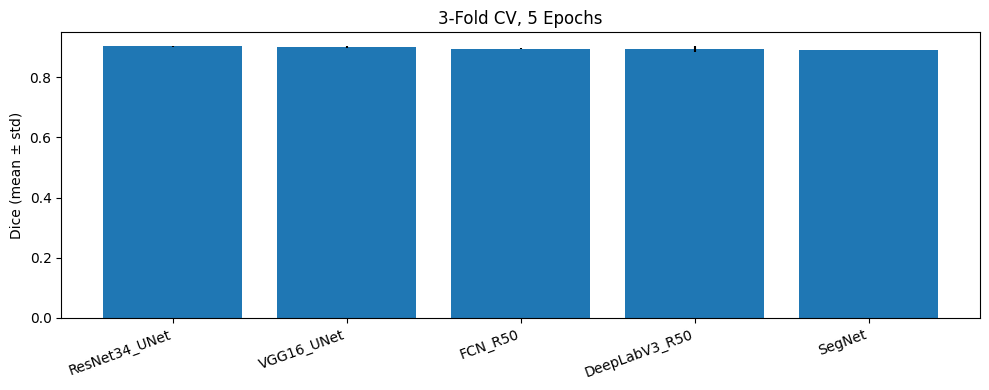

In [16]:
names = []
means = []
stds  = []

print("\n" + "#"*70)
print("CROSS-VALIDATION SUMMARY (Dice)")
print("#"*70)

for name, scores in cv_results.items():
    m = float(np.mean(scores))
    s = float(np.std(scores))
    names.append(name); means.append(m); stds.append(s)
    print(f"{name:15s} mean={m:.4f} std={s:.4f} folds={scores}")

order = np.argsort(means)[::-1]
names = [names[i] for i in order]
means = [means[i] for i in order]
stds  = [stds[i] for i in order]

plt.figure(figsize=(10,4))
plt.bar(names, means, yerr=stds)
plt.ylabel("Dice (mean ± std)")
plt.title(f"3-Fold CV, {EPOCHS} Epochs")
plt.xticks(rotation=20, ha="right")
plt.tight_layout()
plt.show()


Visual sample: ISIC_0000149_aug_008823 | chosen from: ResNet34_UNet


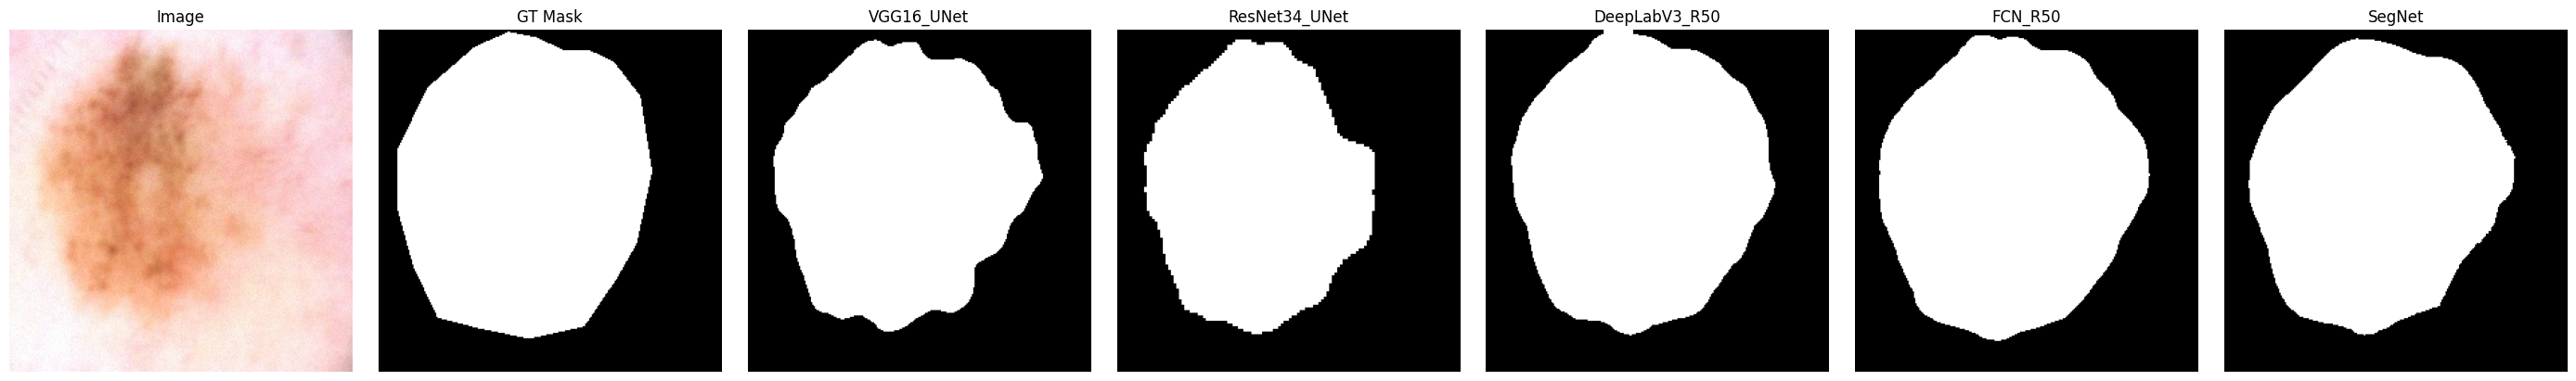

In [17]:
best_name = names[0]
sample_pool = best_models[best_name][1]
sample_id = sample_pool[np.random.randint(0, len(sample_pool))]
print("Visual sample:", sample_id, "| chosen from:", best_name)


raw_img = cv2.imread(os.path.join(IMG_DIR, sample_id + IMG_EXT))
raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
raw_msk = cv2.imread(os.path.join(MASK_DIR, sample_id + MASK_EXT), 0)


tmp_ds = ISICSegDataset(IMG_DIR, MASK_DIR, [sample_id], transform=val_tfms)
img_t, msk_t = tmp_ds[0]
x = img_t.unsqueeze(0).to(DEVICE)


cols = 2 + len(best_models)
plt.figure(figsize=(4*cols, 4))


plt.subplot(1, cols, 1)
plt.imshow(raw_img); plt.axis("off"); plt.title("Image")


plt.subplot(1, cols, 2)
plt.imshow(raw_msk, cmap="gray"); plt.axis("off"); plt.title("GT Mask")


for i, (mname, (m, _)) in enumerate(best_models.items(), start=3):
    m.eval()
    with torch.no_grad():
        logits = m(x)
        prob = torch.sigmoid(logits)[0,0].detach().cpu().numpy()
        pred = (prob > 0.5).astype(np.uint8) * 255

    plt.subplot(1, cols, i)
    plt.imshow(pred, cmap="gray"); plt.axis("off"); plt.title(mname)

plt.tight_layout()
plt.show()


In [15]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        b, c, _, _ = x.size()  
        y = F.adaptive_avg_pool2d(x, (1, 1))  
        y = y.view(b, c)  
        y = self.fc1(y)  
        y = F.relu(y)    
        y = self.fc2(y)  
        y = self.sigmoid(y).view(b, c, 1, 1)
        return x * y.expand_as(x)  

class ResNet34_SE_UNet(nn.Module):
    def __init__(self):
        super().__init__()
        r = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)

        self.e0 = nn.Sequential(r.conv1, r.bn1, r.relu)  
        self.e1 = nn.Sequential(r.maxpool, r.layer1)    
        self.e2 = r.layer2                            
        self.e3 = r.layer3                               
        self.e4 = r.layer4                               

        
        self.se1 = SEBlock(64)  
        self.se2 = SEBlock(128) 
        self.se3 = SEBlock(256) 
        self.se4 = SEBlock(512) 

        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.d3 = ConvBlock(512 + 256, 256)
        self.d2 = ConvBlock(256 + 128, 128)
        self.d1 = ConvBlock(128 + 64, 64)
        self.d0 = ConvBlock(64 + 64, 64)
        self.out = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        a = self.e0(x)   
        b = self.e1(a)   
        b = self.se1(b)  
        c = self.e2(b)   
        c = self.se2(c)  
        d = self.e3(c)   
        d = self.se3(d)  
        e = self.e4(d)   
        e = self.se4(e)  

        x = self.d3(torch.cat([self.up(e), d], 1))   
        x = self.d2(torch.cat([self.up(x), c], 1))   
        x = self.d1(torch.cat([self.up(x), b], 1))   
        x = self.d0(torch.cat([self.up(x), a], 1))   
        x = self.up(x)                               
        return self.out(x)                           



class ConvBlock(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i, o, 3, 1, 1), nn.ReLU(True),
            nn.Conv2d(o, o, 3, 1, 1), nn.ReLU(True),
        )
    def forward(self, x):
        return self.net(x)


In [19]:
model_zoo = {
    "ResNet34_SE_UNet": ResNet34_SE_UNet,
}


cv_results = {name: [] for name in model_zoo}


for name, ctor in model_zoo.items():
    print("\n" + "="*70)
    print("MODEL:", name)
    print("="*70)

    print("Training on the full dataset...")

 
    tr_ds = ISICSegDataset(IMG_DIR, MASK_DIR, all_ids, transform=train_tfms)
    va_ds = ISICSegDataset(IMG_DIR, MASK_DIR, all_ids, transform=val_tfms)

    tr_ld = DataLoader(tr_ds, batch_size=BATCH, shuffle=True, num_workers=0, drop_last=True)
    va_ld = DataLoader(va_ds, batch_size=BATCH, shuffle=False, num_workers=0)


    model = ctor()
    model.to(DEVICE)

  l
    hist, trained = train_one_model(model, tr_ld, va_ld, epochs=EPOCHS)
    
   
    val_dice = hist["val_dice"][-1]   

   
    cv_results[name].append(val_dice)
    print(f"Validation Dice: {val_dice:.4f}")

  
    save_model(trained, name, "Full Dataset", val_dice)

    print(f"\nFinal Dice for {name}: {val_dice:.4f}")



MODEL: ResNet34_SE_UNet
Training on the full dataset...


Epoch 1/3: 100%|██████████| 5000/5000 [3:18:52<00:00,  2.39s/it, batch_loss=0.3021, eta=0.0m]    


Epoch 1/3 | TrainLoss: 0.1636 | ValLoss: 0.1391 | ValDice: 0.8772


Epoch 2/3: 100%|██████████| 5000/5000 [3:08:01<00:00,  2.26s/it, batch_loss=0.0750, eta=0.0m]    


Epoch 2/3 | TrainLoss: 0.1197 | ValLoss: 0.1077 | ValDice: 0.9006


Epoch 3/3: 100%|██████████| 5000/5000 [2:27:24<00:00,  1.77s/it, batch_loss=0.0667, eta=0.0m]   


Epoch 3/3 | TrainLoss: 0.1099 | ValLoss: 0.1116 | ValDice: 0.9040
Validation Dice: 0.9040
Saved model to: saved_models/ResNet34_SE_UNet_foldFull Dataset_dice0.9040.pth

Final Dice for ResNet34_SE_UNet: 0.9040
